In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import optuna

In [ ]:
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=False)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

In [ ]:
device = torch.device("cuda")

We first create custom classes for the distribution of latent variables, $z$ and the input image $x$ since we will be backpropagting through the parameter of these distributions.

First, this is a class that returns the log probability of the normal distribution, $\log(p(x))$ where $x \sim \mathcal{N} (\mu, \sigma) $. This will be used as the distribution for latent variables

In [ ]:
class Normal(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu, std, z):
        sigma = torch.pow(std, 2)
        #probability of a z modelled as a gaussian centered at mu and with variance var
        return -0.5 * torch.log(2 * np.pi * sigma) - torch.pow(z - mu, 2) / (2 * sigma)

This class returns the log probabiliy of the Bernoulli distribution, $\log(p(x))$ where $x \sim$ Bernoulli $(p)$

In [ ]:
class Bernoulli(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #we use the proxy that bernoulli distribution log probability is equivalent to negative logit loss
        self.bernoulli=torch.nn.BCEWithLogitsLoss(reduction="none")

    def forward(self, x_pred, x):
        return  -self.bernoulli(x_pred, x)

The encoder takes an input image and outputs $\mu$ and $\sigma$ to parameterize $p(z|x) = \mathcal{N}(\mu, \sigma)$. Since we are optimizing with respect to the parameters of a probability distribution, we use a reparametrization trick to make sure we can take derivates, $z= \mu + \sigma \cdot \mathcal{N}(0,1)$. When sampling from the distribution, we will also use the same trick.

In [ ]:
class Encoder(torch.nn.Module):
    """
    Class for an encoder with variable latent and input size. Returns a latent variable sampled from the parameterized distribution
    """
    def __init__(self, dim_latent, dim_input):
        super().__init__()
        #Neural network that retunrs mu and sigma parameters for the p(z|x)
        self.network=torch.nn.Sequential(*[torch.nn.Linear(dim_input, dim_latent*2), torch.nn.ReLU(),torch.nn.Linear(dim_latent*2, dim_latent*2),torch.nn.ReLU(),torch.nn.Linear(dim_latent*2, dim_latent*2)])
        #Guassian distribution
        self.normal=Normal()
        #Softplus layer to ensure variance is positive
        self.softplus=torch.nn.Softplus()

    def forward(self,x):
        # get mu and sigma from the network
        mu, sigma=torch.chunk(self.network(x).unsqueeze(1), chunks=2, dim=-1)
        # ensure that variance is positive
        sigma_pos=self.softplus(sigma)
        # get an standard normal function for the reparametrization trick. Note that we add a dimension in the tensor. This is to account for cases where it might be benefecial to generate multiple samples of z from the distribution
        std_normal=torch.randn((mu.shape[0], 1, mu.shape[-1])).to(device)
        # latent variable obtained from the reparatermized trick
        z=mu+sigma*std_normal
        # return log normal of the latent variable obtained from reparameterization. Use this value as for the KL divergence regularizer in the ELBO
        probs_z=self.normal(mu, sigma_pos, z ).sum(-1, keepdim=True)

        return z,probs_z



The decoder takes an latent feature $z$ and computes paramters of 784 bernoulli distributions. We reconstruct $x$ by sampling from these distributions. We output the sampled x from this distribution and the mean $\log q(x|z)$ across the latent samples. For a particular sample, we can return this mean as the product of $\log q(x|z )$ and the probability of that sample being taken from the distribution of latens, which in our case is a standard Gaussian

In [ ]:
class Decoder(torch.nn.Module):

    def __init__(self, dim_latent, dim_input):
        super().__init__()

        #make sure that torch does not compute gradients w.r.t. parameters to the standard Gaussian
        self.register_buffer("z_mu", torch.zeros(dim_latent))
        self.register_buffer("z_sigma", torch.ones(dim_latent))
        # Neural Network to predict the parameters to the Bernoulli distribution
        self.network=torch.nn.Sequential(*[torch.nn.Linear(dim_latent, dim_latent*2), torch.nn.ReLU(),torch.nn.Linear(dim_latent*2, dim_latent*2),torch.nn.ReLU(),torch.nn.Linear(dim_latent*2, dim_input)])
        self.normal=Normal()
        self.bernoulli=Bernoulli()

    def forward(self, x, z):
        # Probability of a sample assuming p(z) is a Standard Gaussian
        p_z = self.normal(self.z_mu, self.z_sigma, z).sum(-1, keepdim=True)
        # parameters for a
        x_ps=self.network(z)
        x_ps, x = torch.broadcast_tensors(x_ps, x.unsqueeze(1))
        #take the log of the bernoulli distribution
        log_p_x = self.bernoulli(x_ps, x).sum(-1, keepdim=True)
        return x_ps, log_p_x + p_z


In [ ]:
#loading the mnist dataset to train
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=512, shuffle=False)

While training we are jointly optimizer the encoder and decoder parameters with the Evidence Lower Bound(ELBO) loss. We have constructed the encoder and decoder such that it returns the probabilities that when summed is equivalent to the ELBO

In [ ]:
def vae_study(trial):

    dim=trial.suggest_int("latent_dim", 5, 9)
    lr = trial.suggest_int("lr", -4, -2)

    lr=10**lr
    latent_dim=2**dim

    print(lr, latent_dim)

    encoder=Encoder(latent_dim,784).to(device)
    decoder=Decoder(latent_dim, 784).to(device)

    opt=torch.optim.RMSprop(list(encoder.parameters()) + list(decoder.parameters()) , lr=lr)

    test_loss=[]

    epochs=10

    for i in range(epochs):
        train_elbo_epoch=0.
        for  x, _ in (train_loader):
            #turn samples into [batch_size,784] dimensions
            x=x.flatten(start_dim=1).to(device)

            #clear all gradients
            encoder.zero_grad()
            decoder.zero_grad()
            opt.zero_grad()



            z, probs_z= encoder(x)
            __, probsxz=decoder(x,z)

            #taking the mean in case multiple samples for z were generated.
            elbo= (probs_z - probsxz).mean(1)

            #taking the loss along all samples in the batch
            loss= elbo.sum(0)

            loss.backward()

            opt.step()

        # performance on the test set
        with torch.no_grad():
            test_elbo_epoch=0.
            for x_test, _ in test_loader:
                x_test=x_test.flatten(start_dim=1).to(device)
                z, probs_z= encoder(x)
                __, probsxz=decoder(x,z)
                elbo= (probs_z - probsxz).mean(1)
                test_elbo_epoch+= elbo.sum(0).detach().cpu().numpy()[0]

            print(test_elbo_epoch)
        test_loss.append(test_elbo_epoch)

    return np.mean(test_loss)/len(test_loss)



In [ ]:
study=optuna.create_study(direction='minimize')
study.optimize(vae_study, n_trials=30, timeout=3600*3)

[I 2023-12-22 01:30:39,102] A new study created in memory with name: no-name-28c42a5d-52ca-49ed-b76f-fe910aab8d0b


0.01 32
338685.974609375
312137.6611328125
289604.390625
257889.248046875
246953.0205078125
253473.470703125
252005.388671875
248916.611328125
271000.4326171875


[I 2023-12-22 01:31:48,421] Trial 0 finished with value: 27215.495224609378 and parameters: {'latent_dim': 5, 'lr': -2}. Best is trial 0 with value: 27215.495224609378.


250883.32421875
0.001 256
284021.1689453125
233993.8125
178831.3203125
185903.1435546875
161051.40087890625
158564.30224609375
156102.1240234375
139907.94384765625
152094.32861328125


[I 2023-12-22 01:32:59,456] Trial 1 finished with value: 17947.709829101565 and parameters: {'latent_dim': 8, 'lr': -3}. Best is trial 1 with value: 17947.709829101565.


144301.43798828125
0.001 512
283060.9736328125
214349.2412109375
170218.6318359375
157542.162109375
129053.76708984375
135067.77392578125
118413.56494140625
107796.62109375
118751.92138671875


[I 2023-12-22 01:34:11,438] Trial 2 finished with value: 15506.862216796875 and parameters: {'latent_dim': 9, 'lr': -3}. Best is trial 2 with value: 15506.862216796875.


116431.564453125
0.001 256
284235.591796875
231352.0791015625
197526.3017578125
167003.046875
162713.009765625
162037.13232421875
150586.96240234375
151596.70654296875
143651.12060546875


[I 2023-12-22 01:35:22,383] Trial 3 finished with value: 17938.096411132814 and parameters: {'latent_dim': 8, 'lr': -3}. Best is trial 2 with value: 15506.862216796875.


143107.68994140625
0.01 512
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 01:36:34,493] Trial 4 failed with parameters: {'latent_dim': 9, 'lr': -2} because of the following error: The value nan is not acceptable.
[W 2023-12-22 01:36:34,494] Trial 4 failed with value nan.


nan
0.0001 64
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 01:37:44,353] Trial 5 failed with parameters: {'latent_dim': 6, 'lr': -4} because of the following error: The value nan is not acceptable.
[W 2023-12-22 01:37:44,353] Trial 5 failed with value nan.


nan
0.01 64
340632.912109375
317342.1474609375
306298.0888671875
260407.015625
231730.8544921875
238217.8564453125
242396.54296875
231302.09375
240007.3876953125


[I 2023-12-22 01:38:53,985] Trial 6 finished with value: 26589.64572265625 and parameters: {'latent_dim': 6, 'lr': -2}. Best is trial 2 with value: 15506.862216796875.


250629.6728515625
0.01 32
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 01:40:03,376] Trial 7 failed with parameters: {'latent_dim': 5, 'lr': -2} because of the following error: The value nan is not acceptable.
[W 2023-12-22 01:40:03,377] Trial 7 failed with value nan.


nan
0.001 256
306735.5703125
229915.0849609375
205126.8974609375
162124.095703125
161166.572265625
159420.138671875
143647.333984375
157532.2373046875
152144.07470703125


[I 2023-12-22 01:41:14,290] Trial 8 finished with value: 18205.616782226563 and parameters: {'latent_dim': 8, 'lr': -3}. Best is trial 2 with value: 15506.862216796875.


142749.6728515625
0.01 512
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 01:42:26,404] Trial 9 failed with parameters: {'latent_dim': 9, 'lr': -2} because of the following error: The value nan is not acceptable.
[W 2023-12-22 01:42:26,404] Trial 9 failed with value nan.


nan
0.0001 32
411388.96875
385643.0546875
360006.0234375
360223.61328125
350552.970703125
349449.119140625
340791.7421875
318915.578125
315454.404296875


[I 2023-12-22 01:43:35,940] Trial 10 finished with value: 34895.32658203125 and parameters: {'latent_dim': 5, 'lr': -4}. Best is trial 2 with value: 15506.862216796875.


297107.18359375
0.001 64
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 01:44:45,878] Trial 11 failed with parameters: {'latent_dim': 6, 'lr': -3} because of the following error: The value nan is not acceptable.
[W 2023-12-22 01:44:45,878] Trial 11 failed with value nan.


nan
0.01 128
336377.9765625
289863.3447265625
262713.8330078125
259061.17578125
250025.421875
224343.1435546875
245466.1064453125
230259.806640625
215926.0263671875


[I 2023-12-22 01:45:56,063] Trial 12 finished with value: 25492.585673828125 and parameters: {'latent_dim': 7, 'lr': -2}. Best is trial 2 with value: 15506.862216796875.


235221.732421875
0.0001 512
285934.7705078125
252256.6494140625
228253.255859375
207365.3935546875
205167.7978515625
185908.44140625
189182.158203125
174348.1591796875
171337.328125


[I 2023-12-22 01:47:08,129] Trial 13 finished with value: 20549.18230957031 and parameters: {'latent_dim': 9, 'lr': -4}. Best is trial 2 with value: 15506.862216796875.


155164.27685546875
0.0001 32
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 01:48:17,477] Trial 14 failed with parameters: {'latent_dim': 5, 'lr': -4} because of the following error: The value nan is not acceptable.
[W 2023-12-22 01:48:17,478] Trial 14 failed with value nan.


nan
0.001 512
228305.076171875
208868.6513671875
158518.85546875
148093.7373046875
144019.4833984375
113737.83984375
112035.6171875
126039.9482421875
101023.62353515625


[I 2023-12-22 01:49:29,569] Trial 15 finished with value: 14538.965810546875 and parameters: {'latent_dim': 9, 'lr': -3}. Best is trial 15 with value: 14538.965810546875.


113253.74853515625
0.0001 128
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 01:50:39,804] Trial 16 failed with parameters: {'latent_dim': 7, 'lr': -4} because of the following error: The value nan is not acceptable.
[W 2023-12-22 01:50:39,805] Trial 16 failed with value nan.


nan
0.0001 128
385029.466796875
338346.529296875
314570.107421875
303981.970703125
281807.1318359375
284738.603515625
264146.4208984375
256386.736328125
250287.5146484375


[I 2023-12-22 01:51:50,256] Trial 17 finished with value: 29187.213017578128 and parameters: {'latent_dim': 7, 'lr': -4}. Best is trial 15 with value: 14538.965810546875.


239426.8203125
0.001 512
258069.5947265625
214182.333984375
175974.6044921875
135663.978515625
130848.3154296875
127468.38671875
123796.66357421875
122089.14599609375
115554.52099609375


[I 2023-12-22 01:53:02,380] Trial 18 finished with value: 15221.890161132813 and parameters: {'latent_dim': 9, 'lr': -3}. Best is trial 15 with value: 14538.965810546875.


118541.4716796875
0.001 512
255980.5927734375
200111.548828125
176639.830078125
146830.5244140625
137910.6865234375
126077.322265625
113526.412109375
125797.240234375
107275.03125


[I 2023-12-22 01:54:14,521] Trial 19 finished with value: 14983.038247070313 and parameters: {'latent_dim': 9, 'lr': -3}. Best is trial 15 with value: 14538.965810546875.


108154.63623046875
0.001 512
257101.689453125
220871.66015625
168323.9873046875
141536.2802734375
136420.37890625
138529.6494140625
124980.33251953125
119487.322265625
112501.17138671875


[I 2023-12-22 01:55:26,673] Trial 20 finished with value: 15283.643686523437 and parameters: {'latent_dim': 9, 'lr': -3}. Best is trial 15 with value: 14538.965810546875.


108611.89697265625
0.001 256
277756.88671875
226375.208984375
212181.6083984375
184655.380859375
168123.0390625
155452.6494140625
140879.646484375
155485.99951171875
154227.11083984375


[I 2023-12-22 01:56:37,780] Trial 21 finished with value: 18188.830390625 and parameters: {'latent_dim': 8, 'lr': -3}. Best is trial 15 with value: 14538.965810546875.


143745.5087890625
0.0001 128
372015.830078125
353316.1796875
320284.01953125
316104.98046875
286699.8662109375
279030.1005859375
269230.4580078125
256296.291015625
230027.9228515625


[I 2023-12-22 01:57:48,052] Trial 22 finished with value: 29110.50448242187 and parameters: {'latent_dim': 7, 'lr': -4}. Best is trial 15 with value: 14538.965810546875.


228044.7998046875
0.01 512
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 01:59:00,243] Trial 23 failed with parameters: {'latent_dim': 9, 'lr': -2} because of the following error: The value nan is not acceptable.
[W 2023-12-22 01:59:00,244] Trial 23 failed with value nan.


nan
0.01 512
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 02:00:12,219] Trial 24 failed with parameters: {'latent_dim': 9, 'lr': -2} because of the following error: The value nan is not acceptable.
[W 2023-12-22 02:00:12,220] Trial 24 failed with value nan.


nan
0.01 512
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 02:01:24,222] Trial 25 failed with parameters: {'latent_dim': 9, 'lr': -2} because of the following error: The value nan is not acceptable.
[W 2023-12-22 02:01:24,223] Trial 25 failed with value nan.


nan
0.01 512
nan
nan
nan
nan
nan
nan
nan
nan
nan


[W 2023-12-22 02:02:36,247] Trial 26 failed with parameters: {'latent_dim': 9, 'lr': -2} because of the following error: The value nan is not acceptable.
[W 2023-12-22 02:02:36,248] Trial 26 failed with value nan.


nan
0.01 512
722902.33203125
672088.23046875
330554.546875
312367.3759765625
279977.833984375
245080.5078125
243083.7734375
251667.7890625
238931.2744140625


[I 2023-12-22 02:03:48,200] Trial 27 finished with value: 35412.54287109375 and parameters: {'latent_dim': 9, 'lr': -2}. Best is trial 15 with value: 14538.965810546875.


244600.623046875
0.001 256
279387.2666015625
236825.19140625
184926.3369140625
168088.3408203125
155009.55224609375
156440.37451171875
152397.71826171875
162315.1220703125
153687.94775390625


[I 2023-12-22 02:04:59,092] Trial 28 finished with value: 17954.303466796875 and parameters: {'latent_dim': 8, 'lr': -3}. Best is trial 15 with value: 14538.965810546875.


146352.49609375
0.0001 64
399141.77734375
374977.841796875
366222.0703125
339352.490234375
327390.7373046875
323042.4990234375
302220.4560546875
274018.6103515625
270247.6181640625


[I 2023-12-22 02:06:08,863] Trial 29 finished with value: 32450.422138671875 and parameters: {'latent_dim': 6, 'lr': -4}. Best is trial 15 with value: 14538.965810546875.


268428.11328125


In [ ]:
study.best_params

{'latent_dim': 9, 'lr': -3}

Please note that some of the test results have nans in them. After inspection, it seems like a particular combination of learning rates and latent sizes make the ELBO explode for certain batches. I also noticed that a higher precision ( i.e using 0.010000009 instead of 0.01 as the learning rate) soemtimes leads to the losses exploding.


 More work could be done here to analzye why and for which batches this happens, but for the sake of brevity I have excluded this analysis and picked the best performing hyperparameters.

In [ ]:
lr = 10**-3

latent_dim=2**9

encoder=Encoder(latent_size,784).to(device)
decoder=Decoder(latent_size, 784).to(device)

opt=torch.optim.RMSprop(list(encoder.parameters()) + list(decoder.parameters()) , lr=lr)

train_loss=[]
test_loss=[]

epochs=100

for i in range(epochs):
    train_elbo_epoch=0.
    for  x, _ in (train_loader):
        x=x.flatten(start_dim=1).to(device)

        encoder.zero_grad()
        decoder.zero_grad()
        opt.zero_grad()

        z, probs_z= encoder(x)
        __, probsxz=decoder(x,z)
        elbo= (probs_z - probsxz).mean(1)
        loss= elbo.sum(0)
        loss.backward()
        train_elbo_epoch+=loss.detach().cpu().numpy()[0]
        opt.step()

    with torch.no_grad():
        test_elbo_epoch=0.
        for x_test, _ in test_loader:
            x_test=x_test.flatten(start_dim=1).to(device)
            z, probs_z= encoder(x_test)
            __, probsxz=decoder(x_test,z)
            elbo= (probs_z - probsxz).mean(1)
            test_elbo_epoch+= elbo.sum(0).detach().cpu().numpy()[0]

    train_loss.append(train_elbo_epoch)
    test_loss.append(test_elbo_epoch)



# Training Loss

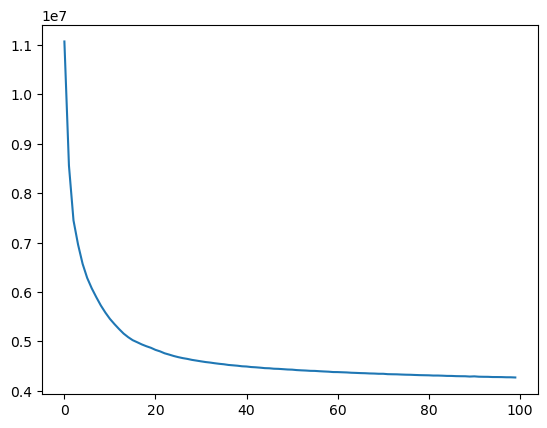

In [ ]:
plt.plot([i for i in range(len(train_loss))], train_loss)

# Test Loss

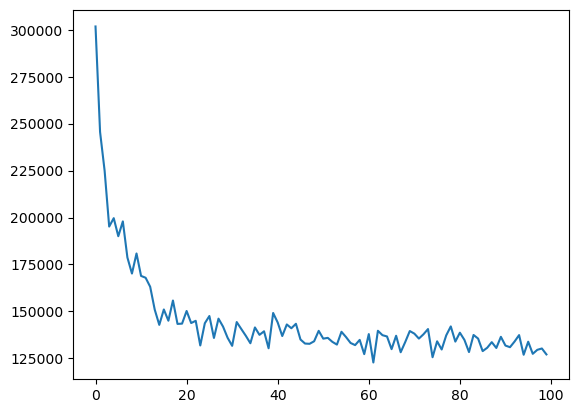

In [ ]:
plt.plot([i for i in range(len(test_loss))], test_loss)

# Latent Variables plot for each class

In [ ]:
vars_dict={0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for data in test_dataset:
    if len(vars_dict[data[1]]) <100:
        vars_dict[data[1]].append(data[0])

In [ ]:
z1=[]
z2=[]
z_label=[]

for k in vars_dict:
    z1_grouped=[]
    z2_grouped=[]
    label=[]
    for x in vars_dict[k]:
        x=x.flatten(start_dim=1).to(device)
        z, probs_z= encoder(x)
        z1_grouped.append(z[0][0][0].detach().cpu().numpy())
        z2_grouped.append(z[0][0][1].detach().cpu().numpy())
        label.append(k)

    z1.append(z1_grouped)
    z2.append(z2_grouped)
    z_label.append(label)

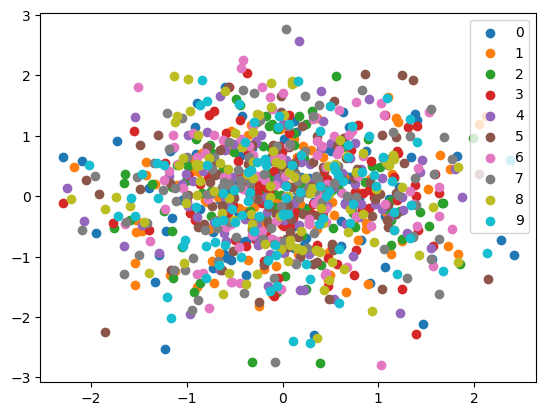

In [ ]:
for i in range(10):
    plt.scatter(z1[i], z2[i],  label=i)
plt.legend()

# Reconstruction for each class

In [ ]:
import random

In [ ]:
def get_reconstructed_image(x):
    x=x.flatten(start_dim=1).to(device)
    z, probs_z= encoder(x)
    genx, probsxz=decoder(x,z)

    # For the sake of simplicty, I have simplified the process of smapling from the bernoulli distribution by creating a certain probabilistic threshold. I choose 0.01 as this threshold since most of the parameters value seem to be negative or very small.
    # Each pixel in the image will have values in (0,1) as a result of this simplistic sampling

    return (genx.detach().cpu().numpy()>0.01).astype(int).reshape(28,28)

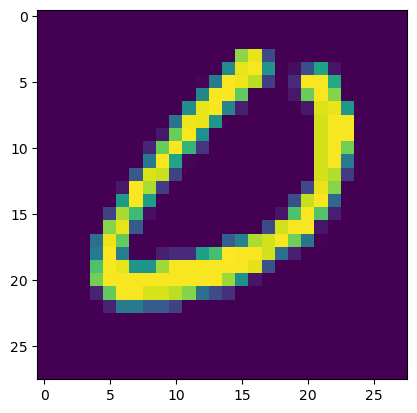

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[0][index].cpu().numpy().reshape(28,28))

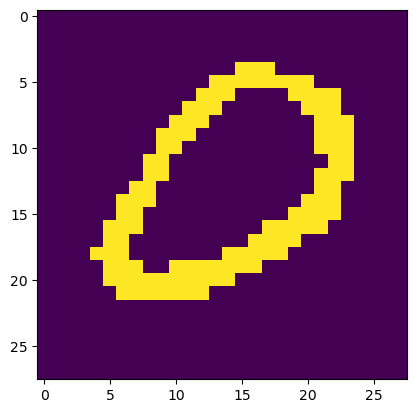

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[0][index]).reshape(28,28))

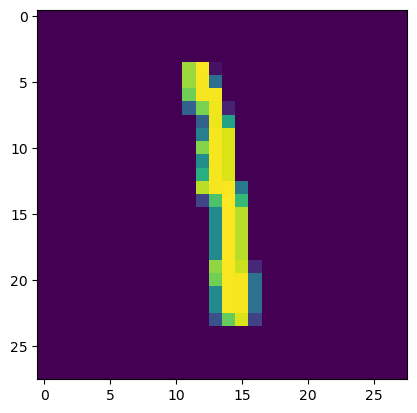

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[1][index].cpu().numpy().reshape(28,28))

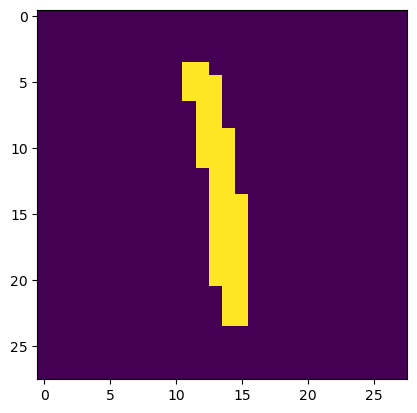

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[1][index]).reshape(28,28))

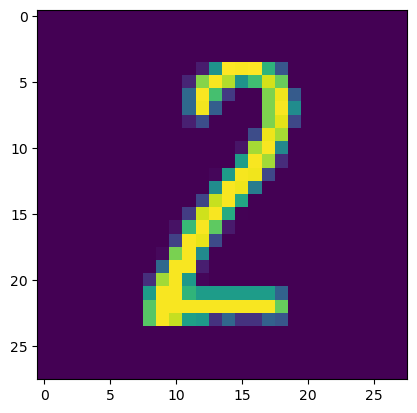

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[2][index].cpu().numpy().reshape(28,28))

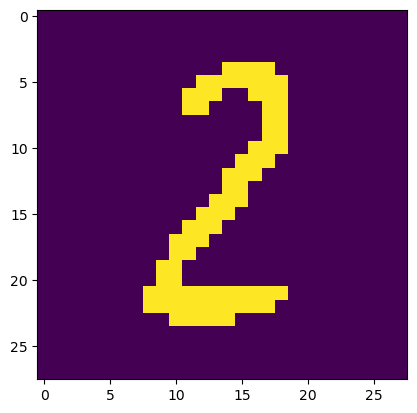

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[2][index]).reshape(28,28))

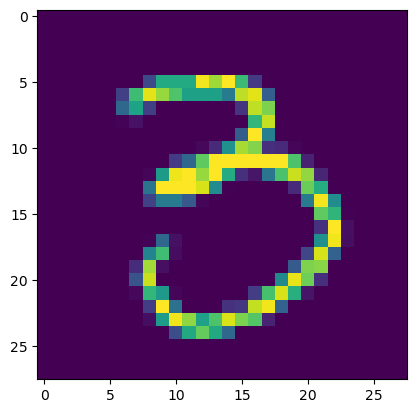

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[3][index].cpu().numpy().reshape(28,28))

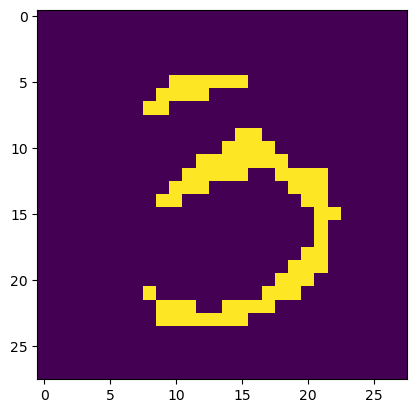

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[3][index]).reshape(28,28))

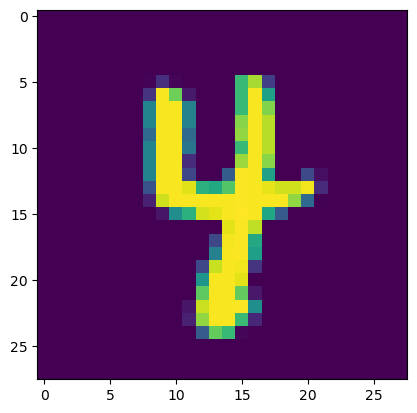

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[4][index].cpu().numpy().reshape(28,28))

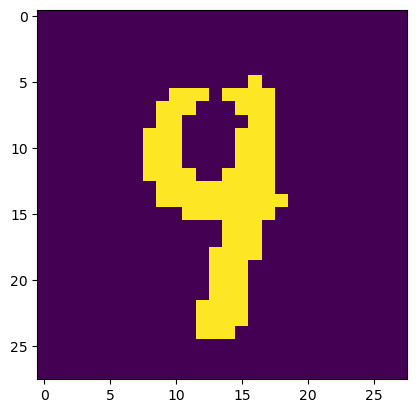

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[4][index]).reshape(28,28))

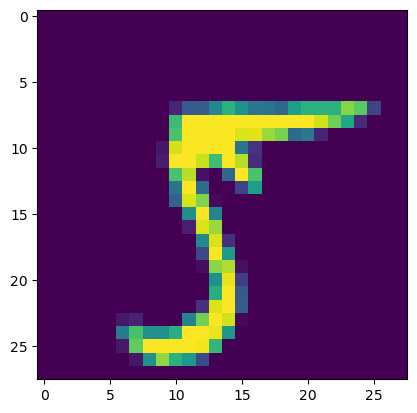

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[5][index].cpu().numpy().reshape(28,28))

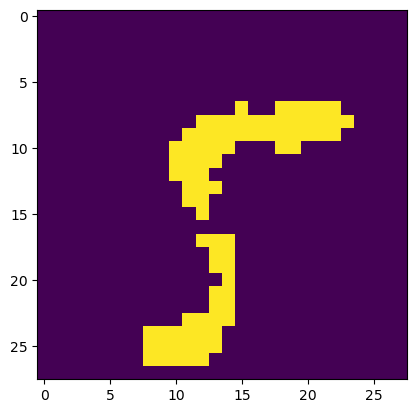

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[5][index]).reshape(28,28))

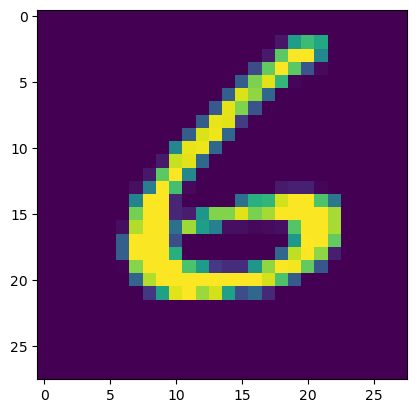

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[6][index].cpu().numpy().reshape(28,28))

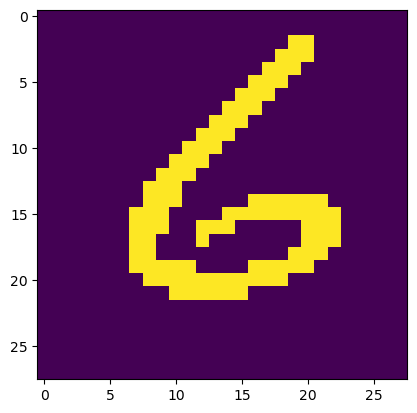

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[6][index]).reshape(28,28))

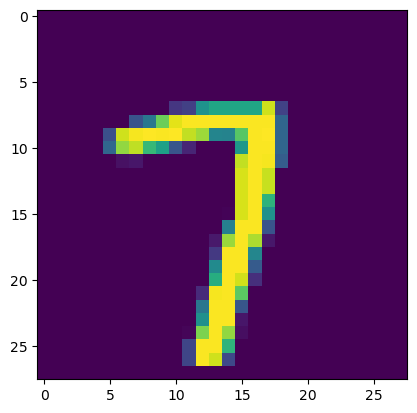

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[7][index].cpu().numpy().reshape(28,28))

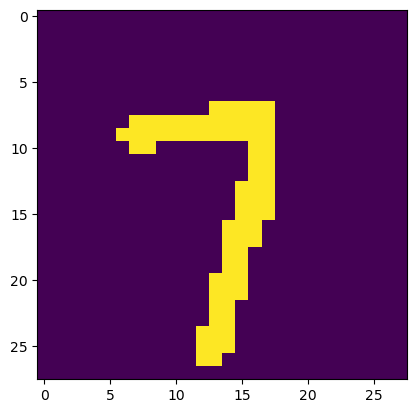

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[7][index]).reshape(28,28))

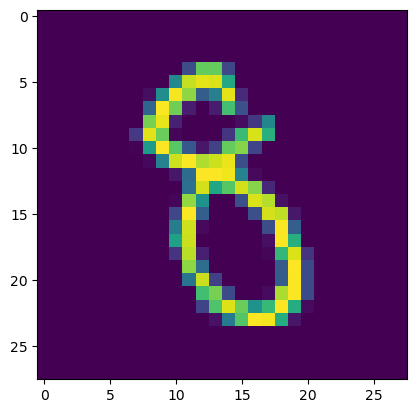

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[8][index].cpu().numpy().reshape(28,28))

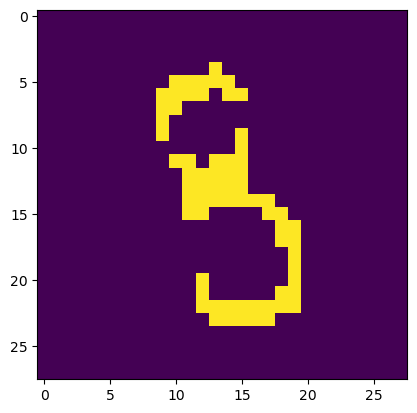

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[8][index]).reshape(28,28))

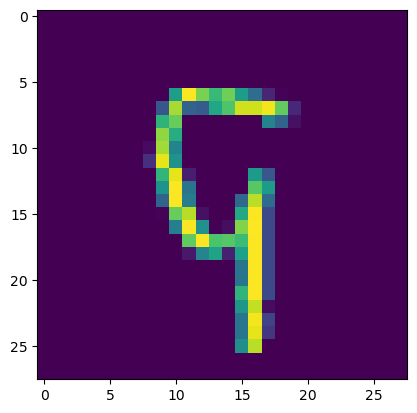

In [ ]:
index=random.randint(0,100)
plt.imshow(vars_dict[9][index].cpu().numpy().reshape(28,28))

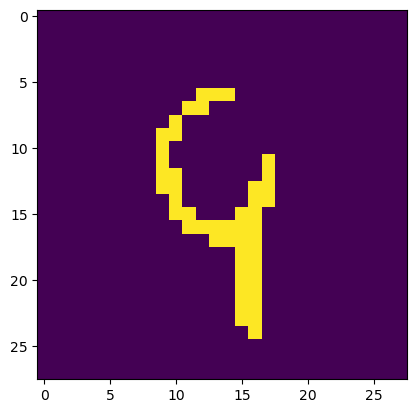

In [ ]:
plt.imshow(get_reconstructed_image(vars_dict[9][index]).reshape(28,28))